## Library Imports

In [1]:
import numpy as np
import cv2
from sklearn.preprocessing import StandardScaler
from PIL import Image
import os
import random

## Image Matrix Construction

In [2]:
file_dict = {} # dictionary to hold path to each image (for reduced space & faster access time)

def create_vec(location, count_of_same_celebrity=40):
    '''
    Create a random vectorized array with 'n' number of images of each celebrity

    location: location of the master folder
    count_of_same_celebrity: number of random images taken of the same celebrity
    '''
    # Create an empty list to store arrays
    img_arrays = []
    global file_dict

    idx = 0

    for celeb in os.listdir(location):
        celeb_path = os.path.join(location, celeb)
        if not os.path.isdir(celeb_path):
            continue  # Skip if the item in the directory is not a folder

        files = [f for f in os.listdir(celeb_path) if os.path.isfile(os.path.join(celeb_path, f))]

        # Use min() to avoid going beyond the available indices
        selected_files = random.sample(files, min(len(files), count_of_same_celebrity))

        for selected_file in selected_files:
            face_path = os.path.join(celeb_path, selected_file)
            file_dict[idx] = face_path
            idx+=1

            # Open and resize the face image
            face_image = Image.open(face_path).convert("L")  # Convert to grayscale
            resized_face_image = face_image.resize((20, 20))
            img_array = np.array(resized_face_image).flatten()
            img_arrays.append(img_array)

    # Convert the list of arrays into a NumPy array
    img_matrix = np.transpose(img_arrays)

    return img_matrix


I = create_vec('Cropped Celebrity Faces Dataset') 
#I is created by taking 40 images of each celebrity (m = 17*40 = 680) with each image is of size 20*20 (= n)

In [3]:
n = I.shape[0]
m = I.shape[1]
print("n =", n)
print("m =", m)  #To check the size of the image matrix

n = 400
m = 680


In [4]:
mean = np.mean(I, axis=1, keepdims=True)
J = I - mean # Centering the image datas about the mean

In [5]:
# Covariance
A = 1/m * J @ J.T  # A is the covariance matrix that is symmetric. Hence, we apply Zhou and Li (2016) protocol to encrypt A.
A.shape

(400, 400)

## Zhou and Li Encryption

### Generation of B

In [6]:
alpha = np.random.rand()
s = np.random.rand()

P = np.eye(n)[:, np.random.permutation(n)] #Random permutation matrix
signs = np.random.choice([-1, 1], size=n)
M = P * signs #Creates a permutation matrix with non-zero entries as 1 and -1 (as per Zhou and Li(2016) protocol)

# Encryption
B = M @ (alpha*A + s*np.eye(n)) @ M.T

## Cheating performed by cloud

In [7]:
# Eigendecomposition
D, Y = np.linalg.eig(B) 
D1 = np.diag(D) #Formatting D as a 2-D array (n*n)

#Cheating

# Generating random 'cheating' vector k
k = np.random.randn(Y.shape[0],1).reshape(-1) # Randomly generated n*1 vector
k1 = np.square(k) #n*1 vector where k1[i] = k[i]^2

# Distorting the eigendecomposition
D_prime = np.zeros_like(D)
for i in range(len(D)):
    D_prime[i] = D[i] / k1[i]  #Dividing i-th eigenvalue by k[i]^2 
Lambda_prime = np.diag(D_prime)

Y_prime = np.zeros_like(Y)
for i in range(len(k)):
    Y_prime[:, i] = Y[:, i] * k[i] #Multiplying i-th eigenvector with k[i]

## Passing undetected in verification

In [8]:
def is_diagonal_matrix(Z):          #Step 1 of Zhou and Li Verification
    """
    Check if the given matrix Z is a diagonal matrix.
    """
    return np.all(Z == np.diag(np.diagonal(Z)))

def check(Z):
    """
    Check if Z is not a diagonal matrix and output a message if it is not.
    """
    if not is_diagonal_matrix(Z):
        print("reject the wrong result")
        return
    # If Z is a diagonal matrix, you can add any other code here if needed.
    print("It is a diagonal matrix.")

check(Lambda_prime)

It is a diagonal matrix.


In [9]:
l=int(input('No. of trials= ')) #Step 2 of Zhou and Li Verification
for i in range(l):
    e = np.random.choice([0, 1], size=(Y_prime.shape[0]))
    err = np.linalg.norm(Y_prime @ (Lambda_prime @ (Y_prime.T @ e)) - B @ e)

    if err >= 1e-4:
        print("Verification failed")
        break

else:
    print("Verification successful for all trials")

No. of trials= 80
Verification successful for all trials


## As the cheated results passes the verification, client proceeds for decryption (To get back the eigendecomposition of A from ED of B). However, it is the cheated version.

In [10]:
U = M.T @ Y_prime
Lambda = (1/alpha) * (Lambda_prime - s*np.eye(n))

## Proceeding for PCA-based face recognition after getting the eigendecomposition of A. 

In [11]:
#Sorting eigenvectors and eigenvalues (cheated)
Lambda_list = np.diag(Lambda)

sorted_indices = np.argsort(Lambda_list)[::-1] # Sort (cheated) eigenvalues in decreasing order.
U_sorted = U[:, sorted_indices] # Arrange the (cheated) eigenvectors in the same order. 
U_sorted.shape

(400, 400)

In [12]:
# Number of eigenfaces
num_components = 100 #Number of principal components taken
selected_U = U_sorted[:, :num_components]
selected_U.shape
# Project data onto selected eigenvectors (eigenfaces)
W = selected_U.T @ J

W.shape

(100, 680)

## Testing image

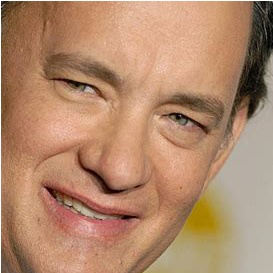

In [13]:
def preprocess_test_image(file_path, target_size=(20, 20)):
    img = Image.open(file_path).convert('L')  # Convert image to grayscale
    img_resized = img.resize(target_size, Image.LANCZOS)  # Resize image to a uniform size
    img_array = np.array(img_resized).flatten()  # Flatten the resized image to a single column vector
    return img_array

# Path to your test image file (replace with the actual path to your test image)
test_image_path = 'Test/Tom Hanks/008_74cd0628.jpg'  # Replace with your test image file path

from IPython.display import display
import matplotlib.pyplot as plt
img = Image.open(test_image_path)
display(img)

In [14]:
# Load and preprocess the test image into a column vector
x = preprocess_test_image(test_image_path)

x_reshaped = x.reshape(-1,1)
x_reshaped.shape

# Normalizing
x_norm = x_reshaped - mean
# Transforming
x_trans = selected_U.T @ x_norm

In [15]:
d = np.linalg.norm(x_trans - W, axis=0)
d_min = np.min(d)
d_index = np.argmin(d)

In [16]:
from IPython.display import display

def display_original(n):
  '''
  n: a number less than A.shape[1] and the index of the image to be displayed
  '''
  global file_dict
  display(Image.open(file_dict[n]))

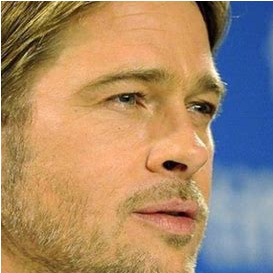

In [17]:
display_original(d_index) #Displaying the detected image

# New Robust Verification Method 

In [18]:
l=int(input('No. of trials'))
for i in range(l):
    e2 = np.random.choice([0, 1], size=(Y_prime.shape[0]))
    err2 = np.linalg.norm(Y_prime.T @ (Y_prime @ e2) - e2)
    
    if err2 >= 1e-4:
        print("Verification failed")
        break
    
    
    e1 = np.random.choice([0, 1], size=(Y_prime.shape[0]))
    err1 = np.linalg.norm(Y_prime @ (Lambda_prime @ (Y_prime.T @ e1)) - B @ e1)
    
    if err1 >= 1e-4:
        print("Verification failed")
        break
else:
    print("Verification successful for all trials")

No. of trials1
Verification failed
